In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

In [2]:
#electricity consumption data
waste_emissions = pd.read_csv('../../../data/tidy/solid-waste-emissions.csv') 

waste_emissions = waste_emissions.drop(columns=['Unnamed: 0'])  # Drop the first column
waste_emissions.set_index('Year', inplace=True)  # Set 'Year' column as index

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
waste_emissions.columns = new_column_names

waste_emissions.index.name = 'year'


waste_emissions.index = pd.to_datetime(waste_emissions.index, format='%Y')
waste_emissions.index.freq = 'AS'
df=waste_emissions
df=df/1000000
df

,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
2010-01-01,0.043626,0.571634,0.275685
2011-01-01,0.042748,0.454075,0.267775
2012-01-01,0.050998,0.454628,0.257262
2013-01-01,0.054846,0.442505,0.263672
2014-01-01,0.038632,0.439828,0.252879
2015-01-01,0.008283,0.414182,0.284651
2016-01-01,0.000000,0.406323,0.287106
2017-01-01,0.000000,0.416470,0.276424
2018-01-01,0.000000,0.332352,0.264719


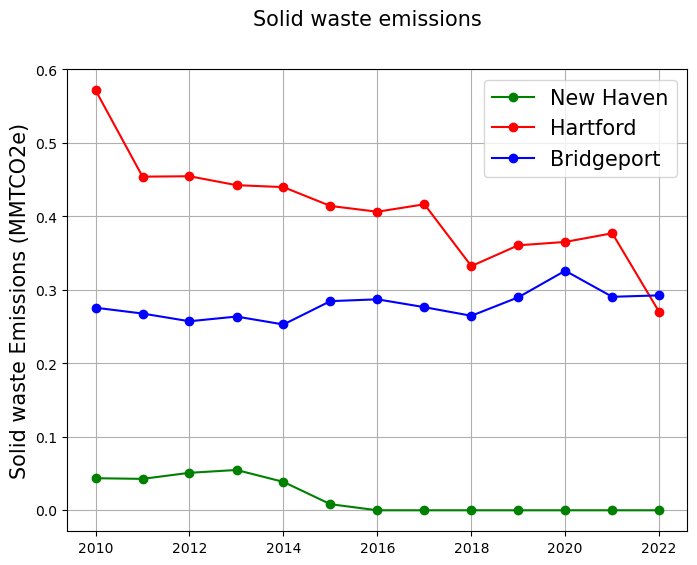

In [3]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Solid waste emissions',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Solid waste Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/solidwaste-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [4]:
#split the test and trainig set
split_index = round(len(df)*0.6)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [5]:
len(df_train)

8

In [6]:
len(df_test)

5

In [7]:
HEM_data = df['Hartford (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']

differenced_NHM = NHM_data.diff().dropna()
differenced_HEM = HEM_data.diff().dropna()
differenced_BSN = BSN_data.diff().dropna()

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">ARIMAX Model</span>

In [8]:

warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,10)
    d_values = range(0,3)
    q_values = range(0,10)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.6)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()
                #print('train',train)
                #print('test',test)

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df
            
    
#split the test and trainig set
split_index = round(len(df)*0.6)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

     p  d  q       MAPE       MAE      RMSE         BIC
0    0  0  0  28.719452  0.091564  0.099327  -32.129502
1    0  0  1  27.809543  0.088518  0.096454  -28.645995
2    0  0  2  34.752648  0.111807  0.118596  252.868665
3    0  0  3  25.778985  0.081746  0.090179  -18.536605
4    0  0  4  22.359781  0.070200  0.080009  -20.242809
..  .. .. ..        ...       ...       ...         ...
295  9  2  5  33.244255  0.105901  0.115516         NaN
296  9  2  6  33.244255  0.105901  0.115516         NaN
297  9  2  7  33.244255  0.105901  0.115516         NaN
298  9  2  8  33.244255  0.105901  0.115516         NaN
299  9  2  9  33.244255  0.105901  0.115516         NaN

[300 rows x 7 columns]


In [9]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_HEM=test_HEM.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_HEM.applymap(lambda x: f'{x:.3f}')
rounded_df

MAPE    MAE   RMSE      BIC
p d q                               
3 2 1   8.820  0.030  0.035  -24.751
4 0 2  10.642  0.036  0.041  -30.287
3 2 0  10.813  0.036  0.041  -51.522
    2  11.009  0.034  0.043  -19.372
0 2 2  13.326  0.041  0.052  -13.239
3 2 3  14.396  0.044  0.055  -15.828
2 2 3  14.046  0.043  0.056  -17.453
  0 1  15.464  0.048  0.059  -28.878
  2 2  15.513  0.048  0.060  -10.694
1 2 3  15.659  0.048  0.061   -8.489

In [10]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_BSN = test_BSN.sort_values(by='RMSE').iloc[:10,:]
rounded_df = sorted_BSN.applymap(lambda x: f'{x:.3f}')
rounded_df

MAPE    MAE   RMSE      BIC
p d q                              
4 2 3  4.406  0.013  0.017  -17.803
0 2 3  5.399  0.016  0.018   -9.733
    2  4.866  0.014  0.018  -11.575
4 2 2  5.316  0.016  0.018  -19.437
1 2 2  5.392  0.016  0.018  -10.619
3 2 3  4.920  0.015  0.018  -20.114
2 2 2  4.521  0.013  0.019   -9.412
  0 3  4.071  0.012  0.019  -16.383
3 2 2  4.707  0.014  0.019   -9.003
2 2 3  5.917  0.017  0.019  -15.012

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Hartford (MMTCO2e)   No. Observations:                   13
Model:                 ARIMA(3, 2, 0)   Log Likelihood                  13.929
Date:                Wed, 08 May 2024   AIC                            -19.858
Time:                        12:47:27   BIC                            -19.541
Sample:                    01-01-2010   HQIC                           -22.002
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2749      0.545     -2.341      0.019      -2.342      -0.208
ar.L2         -1.0714      0.548     -1.953      0.051      -2.146       0.004
ar.L3         -0.6876      0.223     -3.082      0.002      -1.125      -0.250
sigma2         0.0018      0.002      1.165      0.244      -0.001       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.32   Prob(JB):                         0.63
Heteroskedasticity (H):               1.41   Skew:                            -0.67
Prob(H) (two-sided):                  0.79   Kurtosis:                         1.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

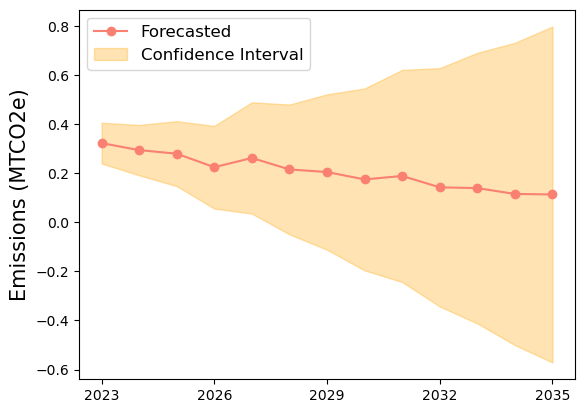

In [11]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('Emissions (MTCO2e)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval

#split the test and trainig set
split_index = round(len(df)*0.6)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-solidwaste.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(3,2,0),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function
HEM_summary.summary()

In [12]:
HEM_summary.pvalues

ar.L1     0.019216
ar.L2     0.050774
ar.L3     0.002057
sigma2    0.244139
dtype: float64

In [13]:
def arima_test_data_performance_metrics(train, test,order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    bic = res.bic

    return mae, rmse, mape,bic

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape,bic = arima_test_data_performance_metrics(HEM_train, HEM_test,(3,2,0))
print(mae)
print(rmse)
print(mape)
print(bic)

0.03643963680514558
0.04063778742203191
10.813439944930536
-51.52239089622088


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Bridgeport (MMTCO2e)   No. Observations:                   13
Model:                   ARIMA(4, 2, 0)   Log Likelihood                  20.215
Date:                  Wed, 08 May 2024   AIC                            -30.430
Time:                          12:47:27   BIC                            -30.700
Sample:                      01-01-2010   HQIC                           -33.773
                           - 01-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1987      0.203     -5.893      0.000      -1.597      -0.800
ar.L2         -1.5258      0.360     -4.237      0.000      -2.232      -0.820
ar.L3         -1.3667      0.345     -3.958      0.000      -2.043      -0.690
ar.L4         -0.6311      0.390     -1.619      0.105      -1.395       0.133
sigma2         0.0002      0.000      0.709      0.478      -0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.24   Prob(JB):                         0.69
Heteroskedasticity (H):               1.55   Skew:                            -0.34
Prob(H) (two-sided):                  0.78   Kurtosis:                         1.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

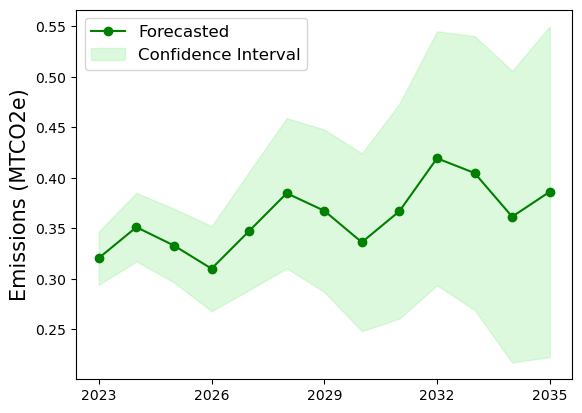

In [14]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-solidwaste.png'  # File to save the plot

BSN_summary,BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(4,2,0),13, plot_file,'green','lightgreen')
BSN_summary.summary()

In [15]:
BSN_summary.pvalues

ar.L1     3.783460e-09
ar.L2     2.270109e-05
ar.L3     7.555289e-05
ar.L4     1.054486e-01
sigma2    4.783290e-01
dtype: float64

In [16]:
mae, rmse, mape,bic = arima_test_data_performance_metrics(BSN_train, BSN_test,(4,2,0))
print(mae,rmse, mape,bic)

0.02115842015371965 0.026223410232462194 7.373924125441866 -38.473735795257326


In [17]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(3,2,0))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(4,2,0))

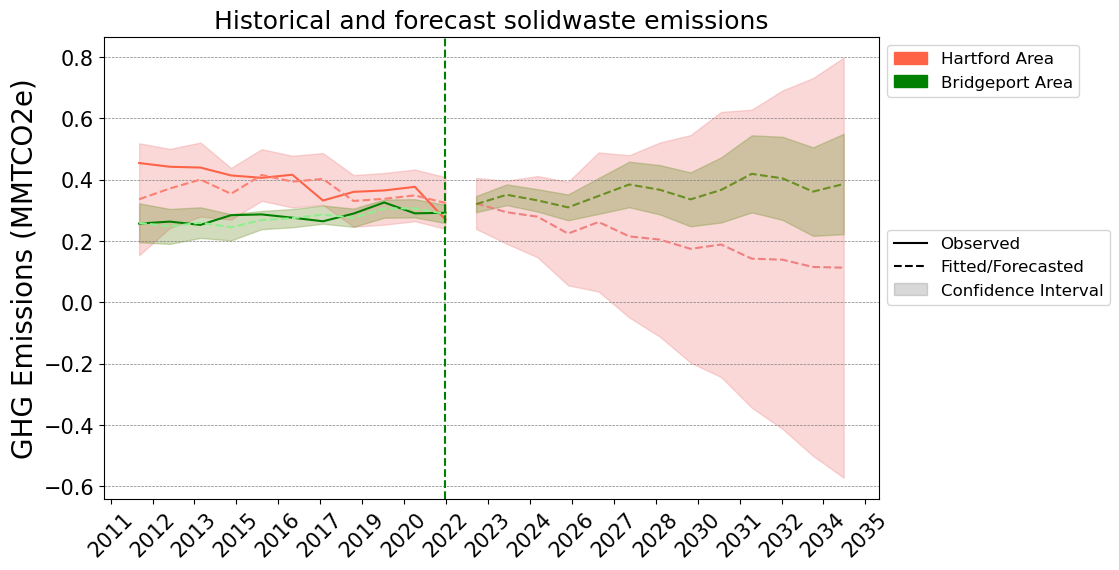

In [18]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[2:]
concatenated_predicted_HEM = emissions_train_HEM[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_HEM.index, concatenated_predicted_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, color='lightcoral', label='Hartford_Forecasted',linestyle='--')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)
plt.fill_between(emissions_train_HEM[1:].index, train_conf_int_HEM.iloc[1:, 0], train_conf_int_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[2:]
concatenated_predicted_BSN = emissions_train_BSN[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_BSN.index, concatenated_predicted_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, color='olivedrab', label='Bridgeport_Forecasted',linestyle='--')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)
plt.fill_between(emissions_train_BSN[1:].index, train_conf_int_BSN.iloc[1:, 0], train_conf_int_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast solidwaste emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')

plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

#max_y_value = 0.8
#plt.yticks(np.arange(0, max_y_value, 0.1))


plt.savefig('../../../figures/solidwaste_forecast.png', dpi=600, bbox_inches='tight')

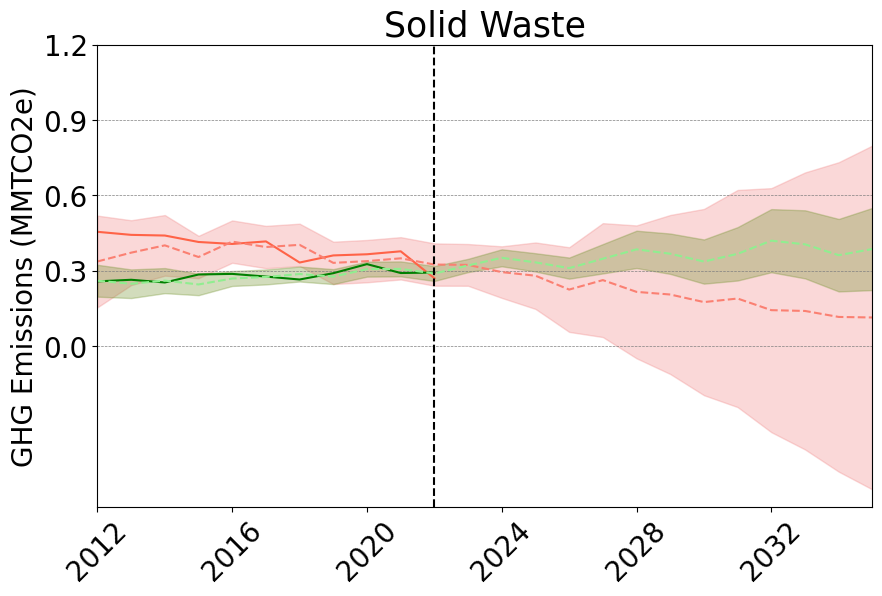

In [26]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

plt.plot(concatenated_observed_HEM[1:].index, concatenated_observed_HEM[1:],label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM[1:].index, concatenated_predicted_forecast_HEM[1:], label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_HEM.index[1:], concatenated_confidence_interval_HEM.iloc[1:, 0], concatenated_confidence_interval_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)




concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN[1:].index, concatenated_observed_BSN[1:],label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN[1:].index, concatenated_predicted_forecast_BSN[1:], label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN[1:].index, concatenated_confidence_interval_BSN.iloc[1:, 0], concatenated_confidence_interval_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, green_patch], title="", fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
#plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=20, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Solid Waste', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# Set starting and ending dates for x-axis ticks
plt.xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2035, 1, 1))



# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')


plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

max_y_value = 1.5
plt.yticks(np.arange(0, max_y_value, 0.3))

plt.savefig('../../../figures/solidwaste_forecast.png', dpi=600, bbox_inches='tight')

In [20]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values



concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,BSN_per)

[69.89508089] [-32.91890996]


In [21]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column3': -BSN_per})
df

,Column1,Column3
0,-69.895081,32.91891


In [22]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

,Column1,Column2,Column5,Column6
0,0.377019,0.113501,0.290551,0.386197


In [23]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

,lower Hartford (MMTCO2e),upper Hartford (MMTCO2e),ME
2011-01-01,-1385.046380,1386.761282,1385.903831
2012-01-01,0.153906,0.519126,0.182610
2013-01-01,0.242557,0.500702,0.129073
2014-01-01,0.279985,0.521395,0.120705
2015-01-01,0.270058,0.438595,0.084268
2016-01-01,0.331347,0.499883,0.084268
2017-01-01,0.309772,0.478309,0.084268
2018-01-01,0.318479,0.487016,0.084268
2019-01-01,0.246709,0.415246,0.084268
2020-01-01,0.253614,0.422151,0.084268


In [24]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN

,lower Bridgeport (MMTCO2e),upper Bridgeport (MMTCO2e),ME
2011-01-01,-1385.490298,1386.317353,1385.903826
2012-01-01,0.196392,0.323338,0.063473
2013-01-01,0.190884,0.304903,0.057009
2014-01-01,0.210346,0.310280,0.049967
2015-01-01,0.202286,0.287859,0.042786
2016-01-01,0.238931,0.298427,0.029748
2017-01-01,0.245099,0.304594,0.029748
2018-01-01,0.256750,0.316246,0.029748
2019-01-01,0.246545,0.306041,0.029748
2020-01-01,0.276207,0.335702,0.029748
